In [1]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import contextily as cx


/home/abdullah/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_5440/3403825677.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeo

### Preprocessing the USA Counties Dataset

- The dataset includes many columns but I'm only concerned with a few of them. I will keep the column I want and drop the rest of them.
- I will only be keeping the data of the counties for which I have Illness data for, and I will drop the rest of them.


In [2]:
usa_counties = gp.read_file("./Datasets/USA_Counties/USA_Counties.shp")

In [3]:
usa_counties.tail()

,NAME,STATE_NAME,POP2010,POP10_SQMI,POP2012,POP12_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,...,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,NO_FARMS07,AVG_SIZE07,CROP_ACR07,AVG_SALE07,SQMI,geometry
3216,Vega Baja,Puerto Rico,-99,-99.0,-99,-99.0,-99,-99,-99,-99,...,-99,-99,-99,-99,-99.0,-99.0,-99.0,-99.0,46.52,"MULTIPOLYGON (((-7389092.135 2095082.949, -738..."
3217,Vieques,Puerto Rico,-99,-99.0,-99,-99.0,-99,-99,-99,-99,...,-99,-99,-99,-99,-99.0,-99.0,-99.0,-99.0,51.00,"POLYGON ((-7287931.984 2048045.066, -7287936.3..."
3218,Villalba,Puerto Rico,-99,-99.0,-99,-99.0,-99,-99,-99,-99,...,-99,-99,-99,-99,-99.0,-99.0,-99.0,-99.0,36.98,"POLYGON ((-7398679.094 2058408.740, -7398662.7..."
3219,Yabucoa,Puerto Rico,-99,-99.0,-99,-99.0,-99,-99,-99,-99,...,-99,-99,-99,-99,-99.0,-99.0,-99.0,-99.0,55.03,"MULTIPOLYGON (((-7324309.318 2045566.508, -732..."
3220,Yauco,Puerto Rico,-99,-99.0,-99,-99.0,-99,-99,-99,-99,...,-99,-99,-99,-99,-99.0,-99.0,-99.0,-99.0,68.81,"POLYGON ((-7439169.322 2057526.561, -7439076.2..."


#### Dropping Unnecessary Columns


In [4]:
usa_counties = usa_counties[["NAME", "STATE_NAME", "geometry"]]
usa_counties["REGION"] = "None"
usa_counties.tail()

,NAME,STATE_NAME,geometry,REGION
3216,Vega Baja,Puerto Rico,"MULTIPOLYGON (((-7389092.135 2095082.949, -738...",None
3217,Vieques,Puerto Rico,"POLYGON ((-7287931.984 2048045.066, -7287936.3...",None
3218,Villalba,Puerto Rico,"POLYGON ((-7398679.094 2058408.740, -7398662.7...",None
3219,Yabucoa,Puerto Rico,"MULTIPOLYGON (((-7324309.318 2045566.508, -732...",None
3220,Yauco,Puerto Rico,"POLYGON ((-7439169.322 2057526.561, -7439076.2...",None


#### Labler Function & Counties Lists


In [5]:
def labler(usa_counties, counties_names, region_name):
    usa_counties.loc[
        usa_counties.isin(counties_names).any(axis=1), "REGION"
    ] = region_name
    return usa_counties


# Bay Area
bay_area_counties = [
    "Alameda",
    "Contra Costa",
    "Marin",
    "Napa",
    "San Francisco",
    "San Mateo",
    "Santa Clara",
    "Santa Cruz",
    "Solano",
    "Sonoma",
]
# Central Valley
cnetral_counties = [
    "Calaveras",
    "Fresno",
    "Inyo",
    "Kings",
    "Madera",
    "Mariposa",
    "Merced",
    "Mono",
    "Monterey",
    "San Benito",
    "San Joaquin",
    "Stanislaus",
    "Tulare",
    "Tuolumne",
]
# Northen
northern_counties = [
    "Alpine",
    "Amador",
    "Butte",
    "Colusa",
    "Del Norte",
    "El Dorado",
    "Glenn",
    "Humboldt",
    "Lake",
    "Lassen",
    "Mendocino",
    "Modoc",
    "Nevada",
    "Placer",
    "Plumas",
    "Sacramento",
    "Shasta",
    "Sierra",
    "Siskiyou",
    "Sutter",
    "Tehama",
    "Trinity",
    "Yolo",
    "Yuba",
]
# Upper Southern
upper_southern_counties = [
    "Kern",
    "Los Angeles",
    "San Luis Obispo",
    "Santa Barbara",
    "Ventura",
]
# Lower Southern
lower_southern_counties = [
    "Imperial",
    "Orange",
    "Riverside",
    "San Bernardino",
    "San Diego",
]

#### Labelling Counties


In [6]:
# Labeling Bay Area Counties
usa_counties = labler(usa_counties, bay_area_counties, "Bay Area")
# Labeling Central Valley Counties
usa_counties = labler(usa_counties, cnetral_counties, "Central")
# Labeling Northern Counties
usa_counties = labler(usa_counties, northern_counties, "Northern")
# Labeling Upper Southern Counties
usa_counties = labler(usa_counties, upper_southern_counties, "Upper Southern")
# Labeling Lower Southern Counties
usa_counties = labler(usa_counties, lower_southern_counties, "Lower Southern")

# Labeling California Counties
# usa_counties.loc[
#     (usa_counties["STATE_NAME"] == "California") & (usa_counties["REGION"] == "None"),
#     "REGION",
# ] = "California"

In [7]:
usa_counties = usa_counties.loc[usa_counties["REGION"] != "None"]
usa_counties = usa_counties.loc[
    (usa_counties["STATE_NAME"] == "Nevada")
    | (usa_counties["STATE_NAME"] == "California")
    | (usa_counties["STATE_NAME"] == "Oregon")
]
usa_counties.head()


,NAME,STATE_NAME,geometry,REGION
84,Kern,California,"POLYGON ((-13119789.473 4272899.442, -13119065...",Upper Southern
94,Kings,California,"POLYGON ((-13342775.428 4356085.351, -13342981...",Central
100,Lake,California,"MULTIPOLYGON (((-13667224.315 4696180.987, -13...",Northern
104,Lassen,California,"POLYGON ((-13418482.359 5039533.376, -13418329...",Northern
139,Los Angeles,California,"POLYGON ((-13159267.125 3996208.125, -13159278...",Upper Southern


#### Plotting Counties


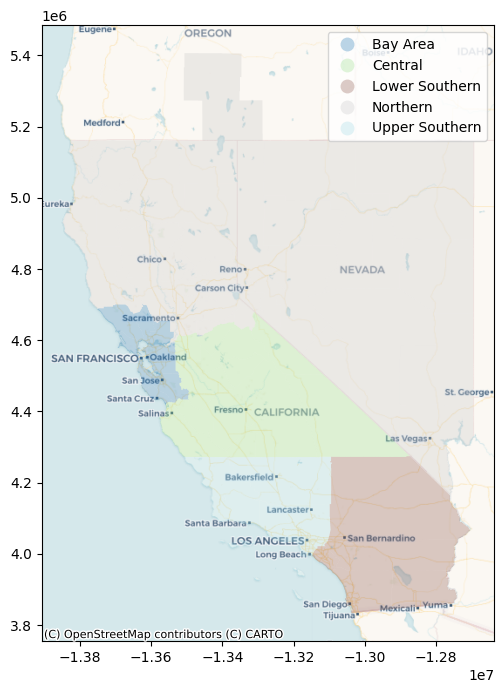

In [8]:
fig, axs = plt.subplots(figsize=(8, 8))
usa_counties.plot(ax=axs, column="REGION", legend=True, cmap="tab20", alpha=0.3)

cx.add_basemap(axs, crs=usa_counties.crs, source=cx.providers.CartoDB.Voyager)

### Preprocessing the AQI Dataset

- The AQI Dataset has day to day values, but I'm going to be needing weekly values of AQI.
- I will aggregate the daily AQI values into weekly values


#### Importing the Dataset


In [9]:
aqi_df = gp.read_file("./Datasets/AQI Dataset by County/daily_aqi_by_county_2017.csv")

In [10]:
aqi_df.tail()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,geometry
326796,Wyoming,Weston,56,045,2017-12-27,39,Good,Ozone,56-045-0003,1,None
326797,Wyoming,Weston,56,045,2017-12-28,36,Good,Ozone,56-045-0003,1,None
326798,Wyoming,Weston,56,045,2017-12-29,31,Good,Ozone,56-045-0003,1,None
326799,Wyoming,Weston,56,045,2017-12-30,31,Good,Ozone,56-045-0003,1,None
326800,Wyoming,Weston,56,045,2017-12-31,26,Good,Ozone,56-045-0003,1,None


In [11]:
aqi_df = aqi_df.loc[aqi_df["county Name"] == usa_counties["NAME"]]

ValueError: Can only compare identically-labeled Series objects

### Preprocessing the Influenza Cases Count Dataset

- This datasets includes the counts of different types of influenza virus cases in different counties of US
- I will only be keeping the data from 2017 to 2020.
- I also don't need the individual count of influenza virus cases, I will only use the total cases.


In [ ]:
illness_df = pd.read_csv(
    "./Datasets/Illness Count Dataset/C_Counts of ILI Diseases by Region.csv"
)

In [ ]:
illness_df


,season,date_code,weekending,region,Influenza_Category,Count
0,2009-2010,200940,10/04/09,Bay Area,Influenza_A,56
1,2009-2010,200940,10/04/09,Bay Area,Influenza_AH3,0
2,2009-2010,200940,10/04/09,Bay Area,Influenza_AH1,0
3,2009-2010,200940,10/04/09,Bay Area,Influenza_AH1pdm09,0
4,2009-2010,200940,10/04/09,Bay Area,Influenza_ANotSubtyped,56
...,...,...,...,...,...,...
30067,2019-2020,202040,09/27/20,Upper Southern,Influenza_BVictoria,0
30068,2019-2020,202040,09/27/20,Upper Southern,Influenza_BYamagata,0
30069,2019-2020,202040,09/27/20,Upper Southern,Influenza_BNotLineageTyped,0
30070,2019-2020,202040,09/27/20,Upper Southern,Influenza_Total,0


- Only keeping data after 2017


In [ ]:
illness_df = illness_df.loc[illness_df["season"] >= "2017-2018"]
illness_df = illness_df.loc[illness_df["Influenza_Category"] == "Influenza_Total"]
illness_df


,season,date_code,weekending,region,Influenza_Category,Count
20660,2017-2018,201740,10/01/17,Bay Area,Influenza_Total,2
20670,2017-2018,201740,10/01/17,California,Influenza_Total,22
20680,2017-2018,201740,10/01/17,Central,Influenza_Total,6
20690,2017-2018,201740,10/01/17,Lower Southern,Influenza_Total,9
20700,2017-2018,201740,10/01/17,Northern,Influenza_Total,0
...,...,...,...,...,...,...
30030,2019-2020,202040,09/27/20,California,Influenza_Total,0
30040,2019-2020,202040,09/27/20,Central,Influenza_Total,0
30050,2019-2020,202040,09/27/20,Lower Southern,Influenza_Total,0
30060,2019-2020,202040,09/27/20,Northern,Influenza_Total,0
